<a href="https://colab.research.google.com/github/jayblue27/portfolio/blob/main/object_detector(%EC%BB%A4%EC%8A%A4%ED%85%80%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%9D%8C%EC%8B%9D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

openCV yolo 구현
- 참고사이트
https://junha1125.github.io/blog/artificial-intelligence/2020-08-19-YOLO_OpenCV_DNN/

In [ ]:
# 구글 드라이브 연동 필요함

In [1]:
!pwd

/content


In [2]:
%cd drive/MyDrive/object_detector/

/content/drive/MyDrive/object_detector


In [3]:
!pwd

/content/drive/MyDrive/object_detector


In [4]:
!ls

config					     object_detector.ipynb
darknet					     test2.jpg
food.codes				     test.jpg
food-dark-yolov3-tiny_3l-v3-2_24000.weights  yolov3.cfg
food-dark-yolov3-tiny_3l-v3-2.cfg	     yolov3.weights
food.names


darknet config, weight 파일 다운로드
- darknet 확인

In [ ]:
# !git clone https://github.com/pjreddie/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 5946, done.
remote: Total 5946 (delta 0), reused 0 (delta 0), pack-reused 5946
Receiving objects: 100% (5946/5946), 6.37 MiB | 7.02 MiB/s, done.
Resolving deltas: 100% (3928/3928), done.
Checking out files: 100% (979/979), done.


image shape: (513, 683, 3)


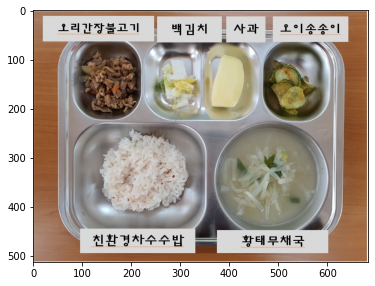

In [88]:
import cv2
import matplotlib.pyplot as plt
from config import config 

%matplotlib inline

img = cv2.imread('./test4.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.show()

In [89]:
# weights 파일 다운
#!wget https://pjreddie.com/media/files/yolov3.weights

In [90]:
# cfg 파일 다운
#!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./yolov3.cfg

In [91]:
import os
#가급적 절대 경로 사용. 
CUR_DIR = os.path.abspath('.')
weights_path = os.path.join(CUR_DIR, 'food-dark-yolov3-tiny_3l-v3-2_24000.weights')
config_path =  os.path.join(CUR_DIR, 'food-dark-yolov3-tiny_3l-v3-2.cfg')
#config 파일 인자가 먼저 옴. 
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)




# Load names of classes from a file
classesFile = os.path.join(CUR_DIR, 'food.names')
classes = None
with open(classesFile, 'rt', encoding='utf-8') as f:
    classes = f.read().rstrip('\n').split('\n')

# Load codes of classes from a file
classes_File_Codes = os.path.join(CUR_DIR, 'food.codes')
classes_codes = None
with open(classes_File_Codes, 'rt', encoding='utf-8') as f:
    classes_codes = f.read().rstrip('\n').split('\n')

In [92]:
labels_to_names_seq = {}

j = 0
for i in classes:
    labels_to_names_seq[j] = i
    j+=1

In [93]:
labels_to_names = {}

j = 1
for i in classes:
    labels_to_names[j] = i
    j+=1

In [94]:
#전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
layer_names = cv_net_yolo.getLayerNames()
# layer_names : ['conv_0', 'bn_0', 'relu_1', 'conv_1', 'bn_1', 'relu_2', 'conv_ ....
outlayer_names = [layer_names[i[0] - 1] for i in cv_net_yolo.getUnconnectedOutLayers()]
# cv_net_yolo.getUnconnectedOutLayers() : [[200], [227], [254]]

print('output_layer name:', outlayer_names)

# Yolov3 416는 416 x 416 Input을 받는다. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
# blobFromImage를 사용해서 CNN에 넣어야할 이미지 전처리를 쉽게 한다.
# DarkNet에서는 scalefactor를 꼭 처리해줘야한다!
out = cv2.dnn.blobFromImage(img, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
print('type : ', type(out))
print('shape :', out.shape)
print('size :', out.size)

 # 말그대로 신경망에 넣을 사진만 Setting 해준다. 
cv_net_yolo.setInput(out)  
# Object Detection 수행하여 결과를 cv_out으로 반환 
cv_outs = cv_net_yolo.forward(outlayer_names)  # inference를 돌려서 원하는 layer의 Feature Map 정보만 뽑아 낸다. 
print('cv_outs type : list // cv_outs length :', len(cv_outs))
print("cv_outs[0] : 첫번째 FeatureMap 13 x 13 x 85, cv_outs[1] : 두번째 FeatureMap 26 x 26 x 85 ")

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)


output_layer name: ['yolo_16', 'yolo_23', 'yolo_30']
type :  <class 'numpy.ndarray'>
shape : (1, 3, 416, 416)
size : 519168
cv_outs type : list // cv_outs length : 3
cv_outs[0] : 첫번째 FeatureMap 13 x 13 x 85, cv_outs[1] : 두번째 FeatureMap 26 x 26 x 85 


In [98]:
import numpy as np

# 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]

conf_threshold = 0.1
nms_threshold = 0.1   # 이 값이 클 수록 box가 많이 사라짐. 조금만 겹쳐도 NMS로 둘 중 하나 삭제하므로

class_ids = []
confidences = []
boxes = []

# 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
for ix, output in enumerate(cv_outs):
    print('output shape:', output.shape)
    # Detected된 Object별 iteration
    for jx, detection in enumerate(output):
        # class score는 detetection배열에서 5번째 이후 위치에 있는 값. 즉 6번쨰~85번째 까지의 값
        scores = detection[5:]
        # scores배열에서 가장 높은 값을 가지는 값이 class confidence, 그리고 그때의 위치 인덱스가 class id
        class_id = np.argmax(scores)
        confidence = scores[class_id] # 5번쨰 값은 objectness score이다. 객체인지 아닌지의 확률이다. 6번쨰~85번째 까지의 값이 그 객체일 확률 값이다. 

        # confidence가 지정된 conf_threshold보다 작은 값은 제외 
        if confidence > conf_threshold:
            print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
            # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
            # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
            center_x = int(detection[0] * cols)
            center_y = int(detection[1] * rows)
            width = int(detection[2] * cols)
            height = int(detection[3] * rows)
            left = int(center_x - width / 2)
            top = int(center_y - height / 2)
            # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
            class_ids.append(class_id)
            confidences.append(float(confidence))

            boxes.append([left, top, width, height])

output shape: (507, 3170)
ix: 0 jx: 248 class_id 515 confidence: 0.4518871
output shape: (2028, 3170)
output shape: (8112, 3170)


In [99]:
conf_threshold = 0.1
nms_threshold = 0.1
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

print(idxs) # 이 index의 box만 살아남았음을 의미한다.

[[0]]


모닝빵: 0.2761


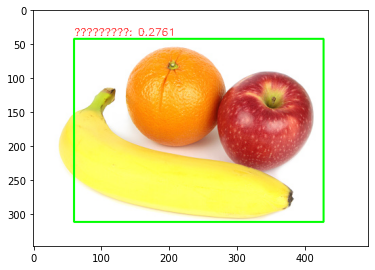

In [78]:
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
        print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.show()

홍시: 0.3595


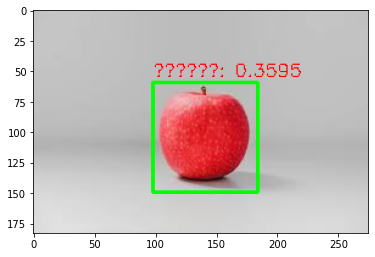

In [87]:
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
        print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.show()

인삼: 0.4519


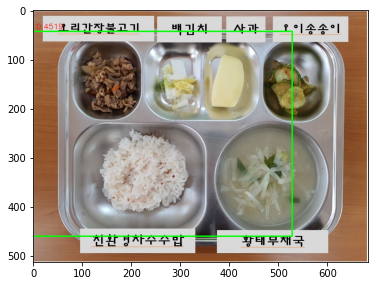

In [100]:
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
        print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.show()